# Data Preparation

Run this notebook to prepare the dataset for the models.

The prepared data are saved as HDF5 and JSON files in the folder `./data`

In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, os

# local imports
import src.utils as utils
import src.ivisc as ivisc

# import sklearn utils
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

# import joblib (save and load models)
import joblib
import h5py


/tmp/ipykernel_89438/316173099.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # manipulate dataframes
2024-03-12 16:09:38.239426: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 16:09:38.482766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been reg

## Dataset preparation

The function below allows preparing the data with a prefered random seed.



In [2]:
# loading the spreadsheets 
dataset_lp = pd.read_excel("./data/database.xlsx", sheet_name="lp")
dataset_hp = pd.read_excel("./data/database.xlsx", sheet_name="hp")

In [3]:
# do we need to process them to get the HDF5 file?
treat_excel = input('do you want to treat the excel file or just load the HDF5 file? type yes or no')

if treat_excel == "yes":
    # Viscosity preparation
    print("Preparing the viscosity datasets...")
    
    # Data  treatment and loading
    ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5', pretreat_data=True, rand_state=172)
    print("Loaded.")

else:
    # Data loading
    print("Loading the viscosity datasets...")
    ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')
    print("Loaded.")

do you want to treat the excel file or just load the HDF5 file? type yes or no yes


Preparing the viscosity datasets...
Reading data...
Preparing the 1 bar dataset with stratified group splitting...
Unique compositions in the train, valid and test subsets:
train 2707, valid 344, test 344
this makes:
train 79.7%, valid 10.1%, test 10.1%

Detection of group (composition) leackage: between
 and train-test:
0 leacked composition between train and valid subsets
0 leacked composition between train and test subsets
Preparing now the high pressure dataset, using train__test_split from Scikit-Learn...
The total number of unique compositions is 215.
Size of viscous training subsets:

(12662, 155)
(1471, 155)
(1727, 155)
Loaded.


# Now statistical observation 

Are the train, validation and test sets similar ? They should be... If the data distribution differs too much, it is obvious that the training will not be optimal. Therefore before doing anything, we must split the datasets in a sensible way.

A way to do it is to play with the random seed until the feature distributions of the train, validation and testing subsets look similar. I followed this blog post:
https://www.yourdatateacher.com/2022/05/02/are-your-training-and-test-sets-comparable/
for implementing this. We basically compare the Kolmogorov-Smirnov distance between the different data subsets and we select a random seed that allows having a minimal distance.

First, I follow the blog example and show how on some features the cumulative distributions look like:

<Axes: xlabel='16', ylabel='Proportion'>

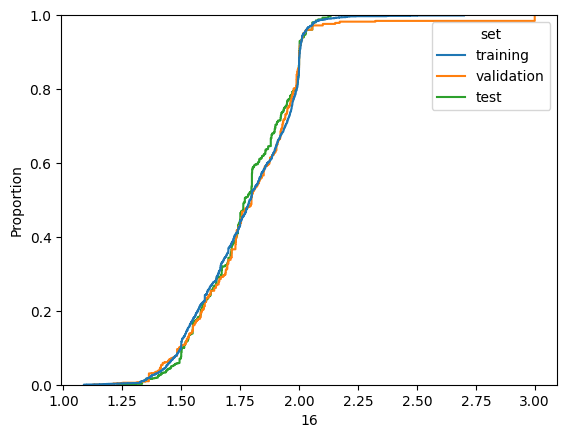

In [4]:
import seaborn as sns
feature_ = 16

df = pd.DataFrame({
    feature_:np.concatenate((ds.TPX_train[:,feature_],
                                 ds.TPX_valid[:,feature_],
                                 ds.TPX_test[:,feature_])),
    'set':['training']*ds.TPX_train.shape[0] 
          + ['validation']*ds.TPX_valid.shape[0]
          + ['test']*ds.TPX_test.shape[0]
    })
sns.ecdfplot(data=df,x=feature_,hue='set')

In [5]:
from scipy.stats import ks_2samp
from tqdm import tqdm

#distances_train_valid = list(map(lambda i : ks_2samp(ds.TPX_train[:,i],ds.TPX_valid[:,i]).statistic,range(14)))
#distances_train_test = list(map(lambda i : ks_2samp(ds.TPX_train[:,i],ds.TPX_test[:,i]).statistic,range(14)))
#max(max(distances_train_test),max(distances_train_valid))

n_tries = 200

#Now we sort this list and get the random seed that allows obtaining a minimal KC distance among the features in the train, validation and testing subsets.

result = []

for random_state in tqdm(range(n_tries)):
    ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5', pretreat_data=True, verbose=False, rand_state=random_state)
    distances_train_valid = list(map(lambda i : ks_2samp(ds.TPX_train[:,i],ds.TPX_valid[:,i]).statistic,range(0,14)))
    distances_train_test = list(map(lambda i : ks_2samp(ds.TPX_train[:,i],ds.TPX_test[:,i]).statistic,range(0,14)))

    result.append((random_state,np.mean((distances_train_test,distances_train_valid))))

  4%|█▌                                         | 7/200 [00:11<05:24,  1.68s/it]/home/charles/miniconda3/envs/gpflow/lib/python3.11/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
  6%|██▎                                       | 11/200 [00:18<05:18,  1.69s/it]/home/charles/miniconda3/envs/gpflow/lib/python3.11/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
 12%|████▊                                     | 23/200 [00:38<04:47,  1.63s/it]/home/charles/miniconda3/envs/gpflow/lib/python3.11/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
 16%|██████▋                                   | 32/200 [00:53<04:42,  1.68s/it]/home/charles/miniconda3/envs

Now we sort this list and get the random seed that allows obtaining a minimal KC distance among the features in the train, validation and testing subsets.

In [6]:
result.sort(key = lambda x : x[1])
print('Suggested good seeds:')
result[0:10]


Suggested good seeds:


[(143, 0.03729082984474435),
 (53, 0.03737945420598562),
 (83, 0.03753769817209577),
 (123, 0.03840556540753074),
 (131, 0.03899754323731638),
 (181, 0.03981809802138755),
 (65, 0.0399130954934105),
 (127, 0.04004433009845381),
 (117, 0.04021169013209956),
 (13, 0.04025173231865605)]

In [7]:
ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5', pretreat_data=True, rand_state=143)

Reading data...
Preparing the 1 bar dataset with stratified group splitting...
Unique compositions in the train, valid and test subsets:
train 2718, valid 339, test 338
this makes:
train 80.1%, valid 10.0%, test 10.0%

Detection of group (composition) leackage: between
 and train-test:
0 leacked composition between train and valid subsets
0 leacked composition between train and test subsets
Preparing now the high pressure dataset, using train__test_split from Scikit-Learn...
The total number of unique compositions is 215.
Size of viscous training subsets:

(12902, 155)
(1550, 155)
(1408, 155)


and let's have a quick look at the cumulative distribution of some feature

<Axes: xlabel='16', ylabel='Proportion'>

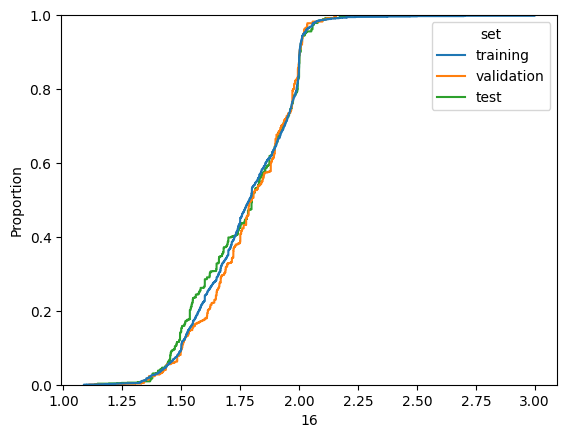

In [8]:
import seaborn as sns
feature_ = 16

df = pd.DataFrame({
    feature_:np.concatenate((ds.TPX_train[:,feature_],
                                 ds.TPX_valid[:,feature_],
                                 ds.TPX_test[:,feature_])),
    'set':['training']*ds.TPX_train.shape[0] 
          + ['validation']*ds.TPX_valid.shape[0]
          + ['test']*ds.TPX_test.shape[0]
    })
sns.ecdfplot(data=df,x=feature_,hue='set')

We can also look at the viscosity vs temperature coverage. One key thing: silica should be in the training set. If not, it is doomed to fail as it is a critical endmember composition.

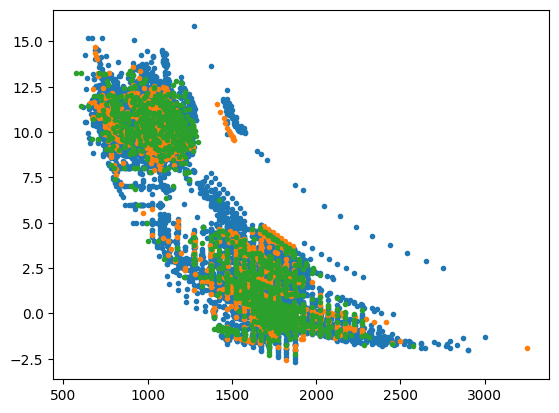

In [9]:
plt.plot(ds.T_train, ds.y_train,".")
plt.plot(ds.T_valid, ds.y_valid,".")
plt.plot(ds.T_test, ds.y_test,".")